## MODERN CNN WITH TF-SLIM

In [1]:
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("CURRENT TF VERSION IS [%s]" % (tf.__version__))
print ("PACKAGES LOADED")

CURRENT TF VERSION IS [1.0.1]
PACKAGES LOADED


## LOAD MNIST

In [2]:
mnist = input_data.read_data_sets('data/', one_hot=True)
trainimg   = mnist.train.images
trainlabel = mnist.train.labels
valimg     = mnist.validation.images
vallabel   = mnist.validation.labels
testimg    = mnist.test.images
testlabel  = mnist.test.labels
print ("MNIST ready")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
MNIST ready


## DEFINE MODEL

In [3]:
n_input = 784
n_classes = 10
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])
is_training = tf.placeholder(tf.bool)

def lrelu(x, leak=0.2, name='lrelu'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

def CNN(inputs, is_training=True):
    x   = tf.reshape(inputs, [-1, 28, 28, 1])
    batch_norm_params = {'is_training': is_training, 'decay': 0.9
                         , 'updates_collections': None}
    init_func = tf.truncated_normal_initializer(stddev=0.01)
    net = slim.conv2d(x, 32, [5, 5], padding='SAME'
                     , activation_fn       = lrelu
                     , weights_initializer = init_func
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='conv1')
    net = slim.max_pool2d(net, [2, 2], scope='pool1')
    net = slim.conv2d(x, 64, [5, 5], padding='SAME'
                     , activation_fn       = lrelu
                     , weights_initializer = init_func
                     , normalizer_fn       = slim.batch_norm
                     , normalizer_params   = batch_norm_params
                     , scope='conv2')
    net = slim.max_pool2d(net, [2, 2], scope='pool2')
    net = slim.flatten(net, scope='flatten3')
    net = slim.fully_connected(net, 1024
                    , activation_fn       = lrelu
                    , weights_initializer = init_func
                    , normalizer_fn       = slim.batch_norm
                    , normalizer_params   = batch_norm_params
                    , scope='fc4')
    net = slim.dropout(net, keep_prob=0.7, is_training=is_training, scope='dr')  
    out = slim.fully_connected(net, n_classes
                               , activation_fn=None, normalizer_fn=None, scope='fco')
    return out
print ("NETWORK READY")

NETWORK READY


## DEFINE GRAPH

In [4]:
# PREDICTION
pred = CNN(x, is_training)

# LOSS AND OPTIMIZER
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        labels=y, logits=pred))
optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) 
corr = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

# INITIALIZER
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print ("FUNCTIONS READY")

FUNCTIONS READY


## CHECK VARIABLES

In [5]:
print ("=================== TRAINABLE VARIABLES ===================")
t_weights = tf.trainable_variables()
var_names_list = [v.name for v in tf.trainable_variables()] 
for i in range(len(t_weights)):
    wval = sess.run(t_weights[i])
    print ("[%d/%d] [%s] / SAHPE IS %s"  
           % (i, len(t_weights), var_names_list[i], wval.shape,))

=================== TRAINABLE VARIABLES ===================
[0/8] [conv1/weights:0] / SAHPE IS (5, 5, 1, 32)
[1/8] [conv1/BatchNorm/beta:0] / SAHPE IS (32,)
[2/8] [conv2/weights:0] / SAHPE IS (5, 5, 1, 64)
[3/8] [conv2/BatchNorm/beta:0] / SAHPE IS (64,)
[4/8] [fc4/weights:0] / SAHPE IS (12544, 1024)
[5/8] [fc4/BatchNorm/beta:0] / SAHPE IS (1024,)
[6/8] [fco/weights:0] / SAHPE IS (1024, 10)
[7/8] [fco/biases:0] / SAHPE IS (10,)


## SAVER

In [6]:
savedir = "nets/cnn_mnist_modern/"
saver = tf.train.Saver(max_to_keep=100)
save_step = 4
if not os.path.exists(savedir):
    os.makedirs(savedir)
print ("SAVER READY")

SAVER READY


## AUGMENTATION

In [7]:
def augment_img(xs):
    out  = np.copy(xs)
    xs_r = np.reshape(xs, [-1, 28, 28])
    for i in range(xs_r.shape[0]):
        xs_img = xs_r[i, :, :]
        bg_value = 0
        # ROTATE
        angle = np.random.randint(-15, 15, 1).astype(float)
        xs_img = ndimage.rotate(xs_img, angle, reshape=False, cval=bg_value)
        # ZOOM
        rg = 0.1
        zoom_factor = np.random.uniform(1., 1.+rg)
        h, w = xs_img.shape[:2]
        zh   = int(np.round(zoom_factor * h))
        zw   = int(np.round(zoom_factor * w))
        top  = (zh - h) // 2
        left = (zw - w) // 2
        zoom_tuple = (zoom_factor,) * 2 + (1,) * (xs_img.ndim - 2)
        temp = ndimage.zoom(xs_img[top:top+zh, left:left+zw], zoom_tuple)
        trim_top  = ((temp.shape[0] - h) // 2)
        trim_left = ((temp.shape[1] - w) // 2)
        xs_img = temp[trim_top:trim_top+h, trim_left:trim_left+w]
        # SHIFT
        shift = np.random.randint(-3, 3, 2)
        xs_img = ndimage.shift(xs_img, shift, cval=bg_value)
        # RESHAPE
        xs_v = np.reshape(xs_img, [1, -1])
        out[i, :] = xs_v
    return out

## TEST AUGMENTATION

/usr/local/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


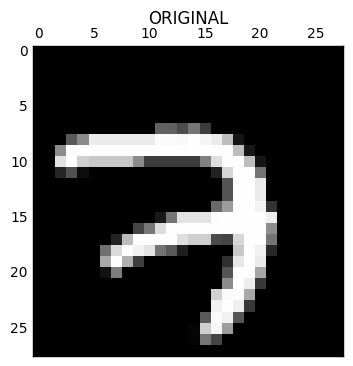

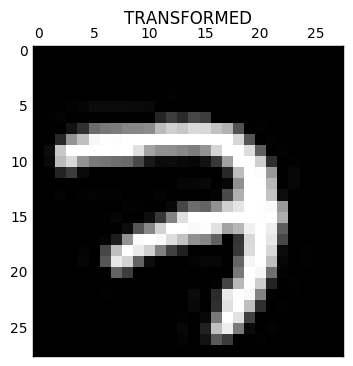

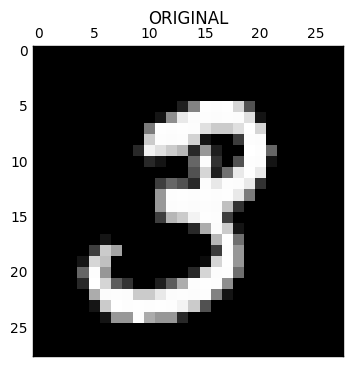

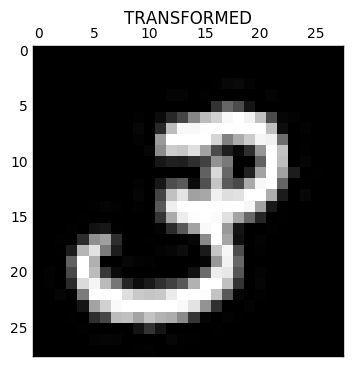

In [8]:
naug = 2
batch_xs = trainimg[:naug, :]
xs2 = augment_img(batch_xs)
for i in range(naug):
    x1 = batch_xs[i, :].reshape([28, 28])
    x2 = xs2[i, :].reshape([28, 28])
    plt.matshow(x1, vmin=0, vmax=1, cmap=plt.cm.gray)
    plt.title("ORIGINAL")
    plt.show()
    plt.matshow(x2, vmin=0, vmax=1, cmap=plt.cm.gray)
    plt.title("TRANSFORMED")
    plt.show()

## RUN

In [ ]:
# PARAMETERS
training_epochs = 100
batch_size      = 50
display_step    = 4
val_acc         = 0
val_acc_max     = 0
# OPTIMIZE
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(mnist.train.num_examples/batch_size)
    # ITERATION
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        # AUGMENT DATA
        batch_xs = augment_img(batch_xs)
        feeds = {x: batch_xs, y: batch_ys, is_training: True}
        sess.run(optm, feed_dict=feeds)
        avg_cost += sess.run(cost, feed_dict=feeds)
    avg_cost = avg_cost / total_batch
    # DISPLAY
    if (epoch+1) % display_step == 0:
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch+1, training_epochs, avg_cost))
        randidx = np.random.permutation(trainimg.shape[0])[:500]
        feeds = {x: trainimg[randidx], y: trainlabel[randidx], is_training: False}
        train_acc = sess.run(accr, feed_dict=feeds)
        print (" TRAIN ACCURACY: %.5f" % (train_acc))
        feeds = {x: valimg, y: vallabel, is_training: False}
        val_acc = sess.run(accr, feed_dict=feeds)
        print (" VALIDATION ACCURACY: %.5f" % (val_acc))
    # SAVE
    if (epoch+1) % save_step == 0:
        savename = savedir + "net-" + str(epoch) + ".ckpt"
        saver.save(sess=sess, save_path=savename)
        print (" [%s] SAVED." % (savename))
    # MAXIMUM VALIDATION ACCURACY
    if val_acc > val_acc_max:
        val_acc_max = val_acc
        best_epoch = epoch
        print ("\x1b[31m BEST EPOCH UPDATED!! [%d] \x1b[0m" % (best_epoch))
print ("OPTIMIZATION FINISHED")

Epoch: 004/100 cost: 0.090395241
 TRAIN ACCURACY: 0.97800
 VALIDATION ACCURACY: 0.98280
 [nets/cnn_mnist_modern/net-3.ckpt] SAVED.
 BEST EPOCH UPDATED!! [3] 
Epoch: 008/100 cost: 0.072734683
 TRAIN ACCURACY: 0.98600
 VALIDATION ACCURACY: 0.98660
 [nets/cnn_mnist_modern/net-7.ckpt] SAVED.
 BEST EPOCH UPDATED!! [7] 
Epoch: 012/100 cost: 0.064491348
 TRAIN ACCURACY: 0.98800
 VALIDATION ACCURACY: 0.98840
 [nets/cnn_mnist_modern/net-11.ckpt] SAVED.
 BEST EPOCH UPDATED!! [11] 
Epoch: 016/100 cost: 0.056388596
 TRAIN ACCURACY: 0.98600
 VALIDATION ACCURACY: 0.98860
 [nets/cnn_mnist_modern/net-15.ckpt] SAVED.
 BEST EPOCH UPDATED!! [15] 
Epoch: 020/100 cost: 0.052543360
 TRAIN ACCURACY: 0.99200
 VALIDATION ACCURACY: 0.99100
 [nets/cnn_mnist_modern/net-19.ckpt] SAVED.
 BEST EPOCH UPDATED!! [19] 
Epoch: 024/100 cost: 0.048470412
 TRAIN ACCURACY: 0.99800
 VALIDATION ACCURACY: 0.99260
 [nets/cnn_mnist_modern/net-23.ckpt] SAVED.
 BEST EPOCH UPDATED!! [23] 
Epoch: 028/100 cost: 0.044348513
 TRAIN ACCU

## COMPUTE TEST ACCURACY

In [9]:
best_epoch = 55
restorename = savedir + "net-" + str(best_epoch) + ".ckpt"
print ("LOADING [%s]" % (restorename))
saver.restore(sess, restorename)
feeds = {x: testimg, y: testlabel, is_training: False}
test_acc = sess.run(accr, feed_dict=feeds)
print ("TEST ACCURACY: %.5f" % (test_acc))

LOADING [nets/cnn_mnist_modern/net-55.ckpt]
TEST ACCURACY: 0.99340
